## Import Libraries

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

## Discriminator Class

In [29]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

## Generator Class

In [30]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

## Initialize the weights and test

In [31]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [32]:
def test():
    N, in_channels, H, W = 8, 3, 64, 64
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"
    print("Success, tests passed!")

In [33]:
test()

Success, tests passed!


## Hyperparameters

In [34]:
# Hyperparameters etc
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 5e-5
BATCH_SIZE = 256
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 128
NUM_EPOCHS = 20
FEATURES_CRITIC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
WEIGHT_CLIP = 0.01

## Dataset Creation

In [35]:
# Dataset
transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

dataset = datasets.FashionMNIST(root=".", transform=transforms, download=False)
#comment mnist and uncomment below if you want to train on CelebA dataset
#dataset = datasets.ImageFolder(root="celeb_dataset", transform=transforms)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [36]:
# initialize gen and disc/critic
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC).to(device)
initialize_weights(gen)
initialize_weights(critic)

# initializate optimizer
opt_gen = optim.RMSprop(gen.parameters(), lr=LEARNING_RATE)
opt_critic = optim.RMSprop(critic.parameters(), lr=LEARNING_RATE)

# for tensorboard plotting
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

gen.train()
critic.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

## Training

In [37]:
for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (data, _) in enumerate(tqdm(loader)):
        data = data.to(device)
        cur_batch_size = data.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(data).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

            # clip critic weights between -0.01, 0.01
            for p in critic.parameters():
                p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0 and batch_idx > 0:
            gen.eval()
            critic.eval()
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(
                    data[:32], normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake[:32], normalize=True
                )

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1
            gen.train()
            critic.train()

 43%|█████████████████▍                       | 100/235 [31:20<39:00, 17.34s/it]

Epoch [0/20] Batch 100/235                   Loss D: -1.3819, loss G: 0.6844


 85%|█████████████████████████████████▏     | 200/235 [1:01:03<09:56, 17.05s/it]

Epoch [0/20] Batch 200/235                   Loss D: -1.5324, loss G: 0.7531


 43%|█████████████████▍                       | 100/235 [31:56<43:02, 19.13s/it]

Epoch [1/20] Batch 100/235                   Loss D: -1.5435, loss G: 0.7590


 85%|█████████████████████████████████▏     | 200/235 [1:02:37<11:20, 19.44s/it]

Epoch [1/20] Batch 200/235                   Loss D: -1.5410, loss G: 0.7586


 43%|█████████████████▍                       | 100/235 [32:15<40:15, 17.89s/it]

Epoch [2/20] Batch 100/235                   Loss D: -1.4752, loss G: 0.7243


 85%|█████████████████████████████████▏     | 200/235 [1:01:20<10:05, 17.30s/it]

Epoch [2/20] Batch 200/235                   Loss D: -1.4605, loss G: 0.6902


 43%|█████████████████▍                       | 100/235 [28:55<38:56, 17.31s/it]

Epoch [3/20] Batch 100/235                   Loss D: -1.2633, loss G: 0.5631


 85%|██████████████████████████████████▉      | 200/235 [57:50<10:02, 17.23s/it]

Epoch [3/20] Batch 200/235                   Loss D: -1.3340, loss G: 0.7044


 43%|█████████████████▍                       | 100/235 [29:04<39:30, 17.56s/it]

Epoch [4/20] Batch 100/235                   Loss D: -1.1662, loss G: 0.7068


 85%|██████████████████████████████████▉      | 200/235 [57:33<09:55, 17.02s/it]

Epoch [4/20] Batch 200/235                   Loss D: -1.2431, loss G: 0.4399


 43%|█████████████████▍                       | 100/235 [28:34<38:23, 17.06s/it]

Epoch [5/20] Batch 100/235                   Loss D: -1.0917, loss G: 0.6660


 85%|██████████████████████████████████▉      | 200/235 [57:08<09:52, 16.93s/it]

Epoch [5/20] Batch 200/235                   Loss D: -1.0917, loss G: 0.6582


 43%|█████████████████▍                       | 100/235 [28:26<38:08, 16.95s/it]

Epoch [6/20] Batch 100/235                   Loss D: -1.1504, loss G: 0.5146


 85%|██████████████████████████████████▉      | 200/235 [56:55<09:55, 17.03s/it]

Epoch [6/20] Batch 200/235                   Loss D: -1.0368, loss G: 0.6145


 43%|█████████████████▍                       | 100/235 [28:21<38:17, 17.02s/it]

Epoch [7/20] Batch 100/235                   Loss D: -1.0960, loss G: 0.5553


 85%|██████████████████████████████████▉      | 200/235 [56:34<09:53, 16.94s/it]

Epoch [7/20] Batch 200/235                   Loss D: -1.0336, loss G: 0.5230


 43%|█████████████████▍                       | 100/235 [28:20<38:34, 17.14s/it]

Epoch [8/20] Batch 100/235                   Loss D: -1.1039, loss G: 0.4532


 85%|██████████████████████████████████▉      | 200/235 [56:36<09:55, 17.01s/it]

Epoch [8/20] Batch 200/235                   Loss D: -1.1303, loss G: 0.6174


 43%|█████████████████▍                       | 100/235 [28:18<37:56, 16.86s/it]

Epoch [9/20] Batch 100/235                   Loss D: -1.1094, loss G: 0.6097


 85%|██████████████████████████████████▉      | 200/235 [56:38<09:49, 16.84s/it]

Epoch [9/20] Batch 200/235                   Loss D: -1.0440, loss G: 0.5858


 43%|█████████████████▍                       | 100/235 [28:20<38:53, 17.28s/it]

Epoch [10/20] Batch 100/235                   Loss D: -1.1065, loss G: 0.5863


 85%|██████████████████████████████████▉      | 200/235 [56:46<09:53, 16.97s/it]

Epoch [10/20] Batch 200/235                   Loss D: -1.0152, loss G: 0.5999


 43%|█████████████████▍                       | 100/235 [28:13<37:52, 16.84s/it]

Epoch [11/20] Batch 100/235                   Loss D: -1.0032, loss G: 0.6029


 85%|██████████████████████████████████▉      | 200/235 [56:33<10:08, 17.38s/it]

Epoch [11/20] Batch 200/235                   Loss D: -0.9928, loss G: 0.5963


 43%|█████████████████▍                       | 100/235 [28:24<38:46, 17.23s/it]

Epoch [12/20] Batch 100/235                   Loss D: -0.9485, loss G: 0.5915


 85%|██████████████████████████████████▉      | 200/235 [56:42<09:57, 17.07s/it]

Epoch [12/20] Batch 200/235                   Loss D: -1.0320, loss G: 0.5782


 43%|█████████████████▍                       | 100/235 [28:23<38:21, 17.05s/it]

Epoch [13/20] Batch 100/235                   Loss D: -1.0114, loss G: 0.5759


 85%|██████████████████████████████████▉      | 200/235 [56:43<09:56, 17.05s/it]

Epoch [13/20] Batch 200/235                   Loss D: -0.9829, loss G: 0.4883


 43%|█████████████████▍                       | 100/235 [28:18<38:22, 17.06s/it]

Epoch [14/20] Batch 100/235                   Loss D: -0.9736, loss G: 0.5895


 85%|██████████████████████████████████▉      | 200/235 [56:38<09:54, 16.99s/it]

Epoch [14/20] Batch 200/235                   Loss D: -0.8434, loss G: 0.3156


 43%|█████████████████▍                       | 100/235 [28:28<38:14, 17.00s/it]

Epoch [15/20] Batch 100/235                   Loss D: -1.0233, loss G: 0.5816


 85%|█████████████████████████████████▏     | 200/235 [1:13:30<16:38, 28.52s/it]

Epoch [15/20] Batch 200/235                   Loss D: -1.1046, loss G: 0.5652


 43%|█████████████████▍                       | 100/235 [30:43<38:29, 17.11s/it]

Epoch [16/20] Batch 100/235                   Loss D: -0.9327, loss G: 0.3761


 85%|██████████████████████████████████▉      | 200/235 [59:35<10:02, 17.23s/it]

Epoch [16/20] Batch 200/235                   Loss D: -0.7525, loss G: 0.2450


 43%|█████████████████▍                       | 100/235 [28:40<38:33, 17.14s/it]

Epoch [17/20] Batch 100/235                   Loss D: -0.9257, loss G: 0.5705


 85%|██████████████████████████████████▉      | 200/235 [57:15<09:58, 17.10s/it]

Epoch [17/20] Batch 200/235                   Loss D: -0.8780, loss G: 0.3416


 43%|█████████████████▍                       | 100/235 [28:31<38:11, 16.98s/it]

Epoch [18/20] Batch 100/235                   Loss D: -0.7204, loss G: 0.5862


 85%|██████████████████████████████████▉      | 200/235 [57:10<10:02, 17.22s/it]

Epoch [18/20] Batch 200/235                   Loss D: -0.9107, loss G: 0.5972


 43%|█████████████████▍                       | 100/235 [28:35<38:40, 17.19s/it]

Epoch [19/20] Batch 100/235                   Loss D: -0.8937, loss G: 0.5575


 85%|██████████████████████████████████▉      | 200/235 [57:01<09:56, 17.05s/it]

Epoch [19/20] Batch 200/235                   Loss D: -0.8195, loss G: 0.2755


100%|███████████████████████████████████████| 235/235 [1:06:46<00:00, 17.05s/it]


## Visualize the results in Tensorboard

In [ ]:
!tensorboard --logdir=logs

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.2.2 at http://localhost:6006/ (Press CTRL+C to quit)


In [38]:
import matplotlib.pyplot as plt

def show_images(img_grid_real, img_grid_fake):
    img_grid_real = img_grid_real.cpu()
    img_grid_fake = img_grid_fake.cpu()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(img_grid_real.permute(1, 2, 0))
    ax1.set_title("Real Images")
    ax2.imshow(img_grid_fake.permute(1, 2, 0))
    ax2.set_title("Fake Images")
    plt.show()

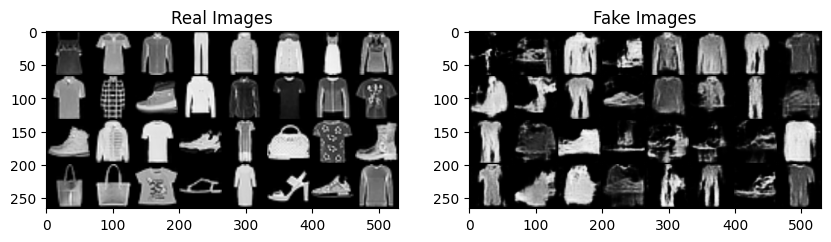

In [39]:
img_grid_real = torchvision.utils.make_grid(
    data[:32], normalize=True
)
img_grid_fake = torchvision.utils.make_grid(
    fake[:32], normalize=True
)

show_images(img_grid_real, img_grid_fake)